In [1]:
import sys
import os

# Model path where RAUNet.py is located
model_path = '/kaggle/input/raunet-model/pytorch/default/1'  # Ensure RAUNet.py is placed here
if model_path not in sys.path:
    sys.path.append(model_path)

# Attempt to import RAUNet
try:
    import RAUNet
    print("RAUNet model successfully imported!")
except ImportError as e:
    print(f"Error importing RAUNet: {e}")
    raise

# Initialize the RAUNet model
try:
    model = RAUNet.RAUNet(num_classes=1, num_channels=3, pretrained=True)
    print("Model initialized successfully!")
    print(model)
except AttributeError as e:
    print(f"Error initializing RAUNet: {e}")


RAUNet model successfully imported!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s]


Model initialized successfully!
RAUNet(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [2]:


import os
import cv2
import albumentations as A

def augment_images_and_masks(image_dir, mask_dir, output_image_dir, output_mask_dir, num_augmentations=4):
    """
    Augments images and their corresponding masks with the same transformations.
    Normalization is applied only to the image, not the mask.

    Args:
        image_dir: Path to the directory containing the images.
        mask_dir: Path to the directory containing the masks.
        output_image_dir: Path to the directory to save augmented images.
        output_mask_dir: Path to the directory to save augmented masks.
        num_augmentations: Number of augmentations to create per image.
    """

    # Create output directories if they don't exist
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_mask_dir, exist_ok=True)

    # Define augmentation pipeline (without normalization)
    transform = A.Compose([
        A.RandomCrop(width=224, height=224),
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5)
        # Add more augmentations (excluding normalization) as needed
    ], additional_targets={'mask': 'mask'})  # Specify mask as an additional target

    # Define normalization transform separately
    #normalize_transform = A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    i=1

    # Iterate through images in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Adjust file extensions as needed
            image_path = os.path.join(image_dir, filename)
            mask_name = filename[:-4] + '_mask.jpg'  # Assuming mask naming convention
            mask_path = os.path.join(mask_dir, mask_name)

            # Read image and mask
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

            # Create multiple augmentations
            for i in range(num_augmentations):
                # Apply augmentations (excluding normalization) to both image and mask
                augmented = transform(image=image, mask=mask)
                augmented_image = augmented['image']
                augmented_mask = augmented['mask']

                # Apply normalization only to the image
                #augmented_image = normalize_transform(image=augmented_image)['image']

                # Save augmented image and mask with unique filenames
                output_image_filename = f"{filename[:-4]}_aug_{i}.jpg"
                output_mask_filename = f"{mask_name[:-4]}_aug_{i}.jpg"
                output_image_path = os.path.join(output_image_dir, output_image_filename)
                output_mask_path = os.path.join(output_mask_dir, output_mask_filename)
                cv2.imwrite(output_image_path, augmented_image)
                cv2.imwrite(output_mask_path, augmented_mask)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
import os

folder_path = '/kaggle/working/augmented/masks'
files = os.listdir(folder_path)  # This lists everything (files and subfolders)

# If you are sure there are only files, you can count them directly:
num_files = len(files)
print("Number of files:", num_files)

Number of files: 14916


In [3]:
train_images_path = '/kaggle/input/training-data-mri/train/images'
train_masks_path = '/kaggle/input/training-data-mri/train/masks'
output_images_path = '/kaggle/working/augmented/images'  # Replace with your desired path
output_masks_path = '/kaggle/working/augmented/masks'  # Replace with your desired path

# Call the function to augment images
augment_images_and_masks(train_images_path, train_masks_path, output_images_path, output_masks_path)

In [34]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import os
import albumentations as A
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch

class CustomDataset(Dataset):
    def __init__(self, images_path, masks_path=None, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.images = os.listdir(images_path)
        self.transform = transform  # Add transform argument
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
        # Check if mask path is provided and set flag
        self.has_masks = masks_path is not None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_file = self.images[idx]
        img_path = os.path.join(self.images_path, image_file)

        # Extract the base filename without extension, considering augmentation pattern
        base_filename = image_file[:-4]  # Remove ".jpg" or other extension
        if '_aug_' in base_filename:
            parts = base_filename.rsplit('_aug_', 1)
            base_filename = parts[0]  # Part before '_aug_'
            aug_suffix = '_aug_' + parts[1]  # Part after '_aug_' including '_aug_'
        else:
            aug_suffix = ''  # No augmentation suffix

        # Read and normalize the image
        image = read_image(img_path).float() / 255.0

        # If mask path is provided, construct the mask filename and read it
        if self.has_masks:
            mask_filename = base_filename + "_mask" + aug_suffix + ".jpg"
            mask_path = os.path.join(self.masks_path, mask_filename)
            mask = read_image(mask_path).float() / 255.0
            mask_np = mask.permute(1, 2, 0).numpy()
        else:
            mask_np = None  # No mask in case masks_path is not provided

        # Convert to NumPy arrays for processing
        image_np = image.permute(1, 2, 0).numpy()  # Transpose to (H, W, C)

        # Apply Min-Max normalization using Scikit-learn
        image_np_reshaped = image_np.reshape(-1, 3)  # Reshape to (H*W, C)
        normalized_image_np = self.scaler.fit_transform(image_np_reshaped)  # Normalize
        
        # Reshape back to original image shape (H, W, C)
        normalized_image_np = normalized_image_np.reshape(image_np.shape)

        # Apply transform if provided
        if self.transform:
            augmented = self.transform(image=normalized_image_np, mask=mask_np)  # Assuming albumentations transform
            normalized_image_np = augmented['image']
            if mask_np is not None:
                mask_np = augmented['mask']

        # Convert back to PyTorch tensors and permute dimensions for model input
        image_tensor = torch.from_numpy(normalized_image_np).permute(2, 0, 1)  # Transpose back to (C, H, W)
        
        if mask_np is not None:
            mask_tensor = torch.from_numpy(mask_np).permute(2, 0, 1)
            return image_tensor, mask_tensor
        else:
            return image_tensor


In [11]:
train_images_path = '/kaggle/working/augmented/images'
train_masks_path = '/kaggle/working/augmented/masks'
train_dataset = CustomDataset(train_images_path, train_masks_path)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


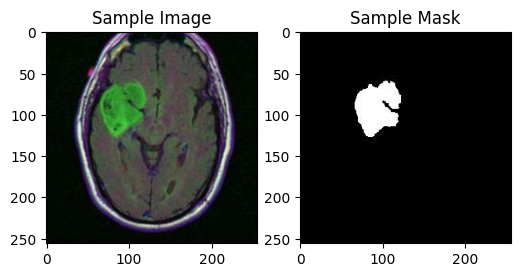

In [12]:
import matplotlib.pyplot as plt
import torch

# Display a sample image from the training dataset
sample_image, sample_mask = train_dataset[0]
print(sample_image.shape)
print(sample_mask.shape)


# Convert the image tensor to a numpy array and transpose for correct channel ordering
plt.figure(figsize=(6,6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.permute(1, 2, 0).numpy())
plt.title("Sample Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask[0].squeeze().numpy(), cmap='gray')
plt.title("Sample Mask")


plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [14]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, outputs, masks):
        smooth = 1e-5
        outputs = torch.sigmoid(outputs)
        intersection = (outputs * masks).sum()
        dice = (2. * intersection + smooth) / (outputs.sum() + masks.sum() + smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.6, weight_bce=0.4):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()  # Replace DiceLoss with your implementation
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce

    def forward(self, pred, target):
        dice_loss_value = self.dice_loss(pred, target)
        bce_loss_value = self.bce_loss(pred, target)
        return self.weight_dice * dice_loss_value + self.weight_bce * bce_loss_value

import torch
import torch.nn as nn

import torch
import torch.nn as nn

class CELDice:
    def __init__(self, dice_weight=0, num_classes=2):
        self.bce_loss = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary segmentation
        self.dice_weight = dice_weight
        self.num_classes = num_classes

    def __call__(self, outputs, targets):
        # BCEWithLogitsLoss combines sigmoid and binary cross-entropy
        loss = (1 - self.dice_weight) * self.bce_loss(outputs, targets)
        
        if self.dice_weight:
            eps = 1e-15
            # For binary segmentation, we only have 2 classes (0 and 1)
            jaccard_target = targets.float()  # targets should be binary (0 or 1)
            jaccard_output = torch.sigmoid(outputs)  # Apply sigmoid to get probability for class 1
            
            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()
            
            # Compute the Dice loss and subtract it from the total loss
            loss -= torch.log((2 * intersection + eps) / (union + eps)) * self.dice_weight

        return loss



In [15]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 5 epochs"""
    lr = 1e-4* (0.8 ** (epoch // 5))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [16]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = CombinedLoss()
opt = optim.Adam(model.parameters(), lr=1e-5)

def train_model(model, train_loader, epochs):
    for epoch in range(epochs):
        epoch_loss=0
        for i,(images,labels) in enumerate(train_loader):
            images=images.to(device)
            labels=labels.to(device)
            pred=model.forward(images)
            loss=criterion(pred,labels)
            opt.zero_grad()
            loss.backward()
            opt.step()
            # adjust_learning_rate(opt,epoch)
            epoch_loss+=loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")

In [17]:
train_model(model,train_loader,20)

Epoch 1/20, Loss: 0.673161795732165
Epoch 2/20, Loss: 0.3071313220588341
Epoch 3/20, Loss: 0.26379605921710036
Epoch 4/20, Loss: 0.22863058566983235
Epoch 5/20, Loss: 0.11180341492895145
Epoch 6/20, Loss: 0.08482748957197127
Epoch 7/20, Loss: 0.07757644419980586
Epoch 8/20, Loss: 0.0741856958545417
Epoch 9/20, Loss: 0.07091282444655704
Epoch 10/20, Loss: 0.06647649761948171
Epoch 11/20, Loss: 0.06386794797109893
Epoch 12/20, Loss: 0.06425085090827456
Epoch 13/20, Loss: 0.060322497519170355
Epoch 14/20, Loss: 0.05920975765119539
Epoch 15/20, Loss: 0.05754751630630524
Epoch 16/20, Loss: 0.056986461773850146
Epoch 17/20, Loss: 0.05470987586035031
Epoch 18/20, Loss: 0.0541878839293924
Epoch 19/20, Loss: 0.05336595941354927
Epoch 20/20, Loss: 0.05073840031550053


In [18]:
model.eval()

RAUNet(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [54]:
test_images_path = '/kaggle/input/testing-data-mri/test/images'
test_masks_path = '/kaggle/input/testing-data-mri/test/masks'
test_dataset = CustomDataset(test_images_path,test_masks_path)

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the same device (GPU or CPU)
model.to(device)
img,mask=test_dataset[101]
out=model(img.unsqueeze(0).to(device))
out = (out > 0.5).to(torch.uint8)


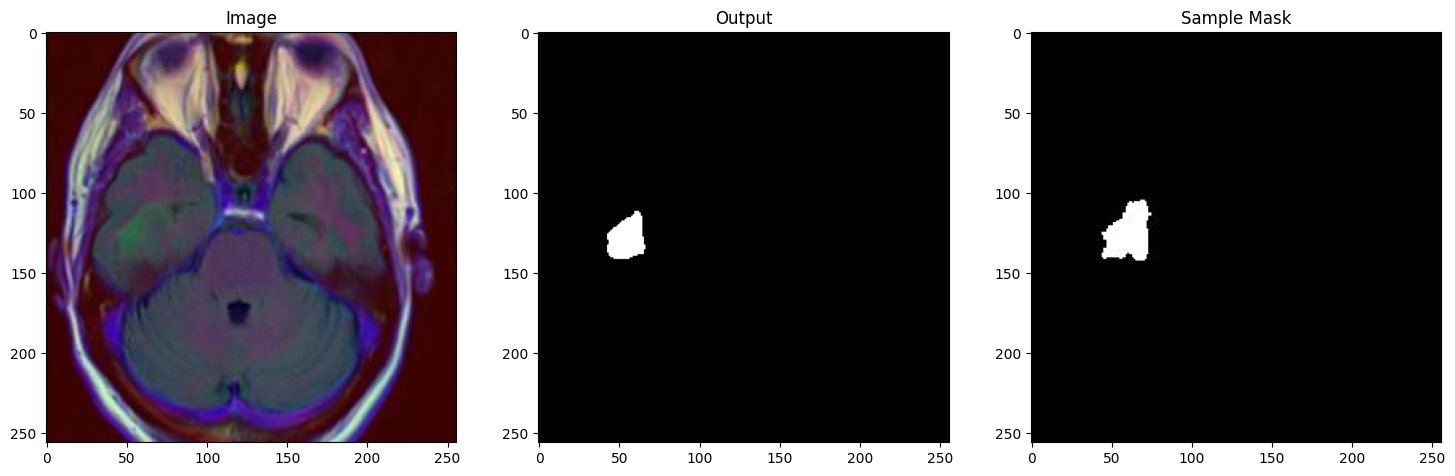

In [85]:
out=out.cpu()
img=img.cpu()
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title("Image")


plt.subplot(1, 3, 2)
plt.imshow(out.squeeze().detach().numpy(), cmap='gray')
plt.title("Output")

plt.subplot(1, 3, 3)
plt.imshow(mask[0].squeeze().numpy(), cmap='gray')
plt.title("Sample Mask")


plt.show()

In [26]:
torch.save(model.state_dict(), 'trained_model.pth')
# Assuming `optimizer` is your optimizer and `epoch` is the current epoch
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'epoch': 20,
    'loss': criterion,
}, f'trained_model.pth')


In [31]:
import sys
import os
import torch

# Model path where RAUNet.py is located
model_path = '/kaggle/input/raunet-model/pytorch/default/1/RAUNet.py'  # Ensure RAUNet.py is placed here
if model_path not in sys.path:
    sys.path.append(model_path)

# Attempt to import RAUNet
try:
    import RAUNet
    print("RAUNet model successfully imported!")
except ImportError as e:
    print(f"Error importing RAUNet: {e}")
    raise

# Initialize the RAUNet model
try:
    model = RAUNet.RAUNet(num_classes=1, num_channels=3, pretrained=False)  # Set pretrained=False to load saved weights
    print("Model initialized successfully!")
    print(model)
except AttributeError as e:
    print(f"Error initializing RAUNet: {e}")

# Load the saved model weights
model_weights_path = '/kaggle/working/trained_model.pth'  # Change this to your saved model's path
try:
    checkpoint = torch.load(model_weights_path, map_location='cpu')  # Load the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])  # Load the model weights from the checkpoint
    print("Model weights loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading model weights: {e}")
except KeyError as e:
    print(f"Error with checkpoint keys: {e}")

# Optionally, set the model to evaluation mode
model.eval()  # or model.train() if you're resuming training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


RAUNet model successfully imported!
Model initialized successfully!
RAUNet(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, 

<ipython-input-31-389da728808c>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_weights_path, map_location='cpu')  # Load the checkpoint


Model weights loaded successfully!


RAUNet(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R